In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import mlflow
import time

import optuna
import optuna.visualization as vis

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV

# Scalers
from sklearn.preprocessing import label_binarize

from imblearn.over_sampling import SMOTE

# Metrics
from sklearn.metrics import classification_report, roc_auc_score, auc, roc_curve, precision_recall_curve, f1_score

# Model
from xgboost import XGBClassifier

# Model Selection - XGBoost

## 1. Load Data

In [34]:
attributes = pd.read_csv("data/btc_price_data_1_year_attributes.csv")
attributes.set_index('timestamp', inplace=True, drop = True)
attributes

,open,high,low,close,volume,month,day,weekday,hour,hour_sin,...,lag_47,lag_56,RSI,EMA12,EMA26,MACD,Signal_Line,SMA,EMA,future_return
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-11-01 00:56:00,34524.12,34549.26,34541.45,34524.49,31.117144,11,1,2,0,0.000000,...,34619.47,34667.88,47.431310,34542.664324,34556.581568,-13.917244,-12.759288,34553.5310,34550.874620,0.000377
2023-11-01 00:57:00,34524.13,34537.66,34524.52,34524.62,7.349951,11,1,2,0,0.000000,...,34603.20,34642.82,48.755135,34539.888274,34554.214045,-14.325771,-13.072585,34549.4505,34548.374180,-0.005330
2023-11-01 00:58:00,34519.85,34531.41,34527.81,34522.78,5.134526,11,1,2,0,0.000000,...,34602.26,34656.56,48.265451,34537.256232,34551.885597,-14.629365,-13.383941,34545.2715,34545.936639,0.025461
2023-11-01 00:59:00,34521.42,34531.98,34521.42,34531.57,4.310564,11,1,2,0,0.000000,...,34623.10,34629.34,41.702541,34536.381427,34550.380738,-13.999311,-13.507015,34542.0065,34544.568387,0.021053
2023-11-01 01:00:00,34531.46,34547.87,34532.22,34538.84,1.327905,11,1,2,1,0.258819,...,34611.54,34622.27,48.144440,34536.759669,34549.525868,-12.766199,-13.358852,34540.4225,34544.022827,0.011263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-31 23:55:00,70248.97,70264.97,70248.98,70248.97,1.604753,10,31,3,23,-0.258819,...,70345.60,70383.13,15.731750,70316.514762,70363.992465,-47.477702,-35.505422,70367.7305,70348.638181,-0.014534
2024-10-31 23:56:00,70238.76,70248.97,70248.97,70238.76,1.189134,10,31,3,23,-0.258819,...,70329.38,70461.07,20.028025,70304.552491,70354.715986,-50.163495,-38.437037,70352.5490,70338.173592,-0.007859
2024-10-31 23:57:00,70218.00,70250.00,70238.77,70233.24,4.767082,10,31,3,23,-0.258819,...,70317.72,70470.15,14.761536,70293.581339,70345.717765,-52.136426,-41.176915,70338.1685,70328.179916,-0.036251


In [35]:
target_data = pd.read_csv("data/btc_price_data_1_year_target.csv")
target_data.set_index('timestamp', inplace=True, drop = True)
target = target_data['target']
target

timestamp
2023-11-01 00:56:00    0
2023-11-01 00:57:00    0
2023-11-01 00:58:00    0
2023-11-01 00:59:00    0
2023-11-01 01:00:00    0
                      ..
2024-10-31 23:55:00    0
2024-10-31 23:56:00    0
2024-10-31 23:57:00    0
2024-10-31 23:58:00    0
2024-10-31 23:59:00    0
Name: target, Length: 528575, dtype: int64

## 2. Data Splitting

In [36]:
attributes_train, attributes_test, target_train, target_test = train_test_split(
    attributes, 
    target, 
    test_size=0.2, 
    shuffle = False,
    random_state = 42
)

In [37]:
attributes_train.shape, attributes_test.shape

((422860, 52), (105715, 52))

In [38]:
target_train.shape, target_test.shape

((422860,), (105715,))

## 3. SMOTE - Address Class Imbalance with SMOTE

In [39]:
# Apply SMOTE to generate synthetic examples for minority classes
smote = SMOTE(random_state=42)
attributes_train_smote, target_train_smote = smote.fit_resample(attributes_train, target_train)

print("Original Class Distribution:", np.bincount(target_train))
print("Balanced Class Distribution:", np.bincount(target_train_smote))

Original Class Distribution: [420626   1040   1194]
Balanced Class Distribution: [420626 420626 420626]


## 4. Train Model

Set time series-specific hyperparameters and tune them for your data:

In [8]:
# Initial XGBoost model with recommended parameters
model_xgb = XGBClassifier(
    objective='multi:softmax',  # Multiclass classification
    num_class=3,                # Number of target classes
    eval_metric='mlogloss',
    max_depth=6,                # Controls model complexity
    learning_rate=0.1,          # Step size for weight updates
    n_estimators=300,           # Number of boosting rounds
    subsample=0.8,              # Fraction of data used for training
    colsample_bytree=0.8,       # Fraction of features used
    scale_pos_weight=1,         # Placeholder for class imbalance
    random_state=42,
    verbosity = 3,
    n_jobs = 9
)

In [9]:
# Train the model
start_time = time.time()
model_xgb.fit(attributes_train_smote, target_train_smote)
print('Fit time : ', time.time() - start_time)

[10:57:47] ======== Monitor (0): HostSketchContainer ========
[10:57:47] AllReduce: 0.028985s, 1 calls @ 28985us

[10:57:47] MakeCuts: 0.029343s, 1 calls @ 29343us

[10:57:47] DEBUG: D:\bld\xgboost-split_1732150467793\work\src\gbm\gbtree.cc:130: Using tree method: 0


C:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:57:47] WARNING: D:\bld\xgboost-split_1732150467793\work\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[10:59:13] ======== Monitor (0): Learner ========
[10:59:13] Configure: 0.002369s, 1 calls @ 2369us

[10:59:13] EvalOneIter: 0.003589s, 300 calls @ 3589us

[10:59:13] GetGradient: 7.79653s, 300 calls @ 7796530us

[10:59:13] PredictRaw: 0.004877s, 300 calls @ 4877us

[10:59:13] UpdateOneIter: 85.7416s, 300 calls @ 85741576us

[10:59:13] ======== Monitor (0): GBTree ========
[10:59:13] BoostNewTrees: 77.9342s, 300 calls @ 77934227us

[10:59:13] CommitModel: 0.000418s, 300 calls @ 418us

[10:59:13] ======== Monitor (0): HistUpdater ========
[10:59:13] BuildHistogram: 21.212s, 4500 calls @ 21211994us

[10:59:13] EvaluateSplits: 2.49352s, 5400 calls @ 2493520us

[10:59:13] InitData: 3.65117s, 900 calls @ 3651167us

[10:59:13] InitRoot: 22.3737s, 900 calls @ 22373666us

[10:59:13] LeafPartition: 0.000234s, 900 calls @ 234us

[10:59:13] UpdatePosition: 9.57417s, 5400 calls @ 9574170us

[10:59:13] UpdatePredictionCache: 2.06756s, 900 calls @ 2067556us

[10:59:13] UpdateTree: 59.2881s, 900 call

## 5. Evaluate the Model

In [10]:
# Predictions
y_pred = model_xgb.predict(attributes_test)
# y_pred = model.predict(X_test)

# Classification Report
print(classification_report(target_test, y_pred))
# print(classification_report(y_test, y_pred))

# ROC-AUC for multiclass
y_prob = model_xgb.predict_proba(attributes_test)
roc_auc = roc_auc_score(target_test, y_prob, multi_class='ovr')
print(f"ROC-AUC Score: {roc_auc}")

# y_prob = model.predict_proba(X_test)
# roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')


[10:59:13] DEBUG: D:\bld\xgboost-split_1732150467793\work\src\gbm\gbtree.cc:130: Using tree method: 0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    105186
           1       0.43      0.11      0.17       265
           2       0.35      0.12      0.18       264

    accuracy                           0.99    105715
   macro avg       0.59      0.41      0.45    105715
weighted avg       0.99      0.99      0.99    105715

ROC-AUC Score: 0.9928168753366418


##### ROC-AUC score

Calculate the ROC-AUC score for each class individually to understand how well the model performs for the minority classes (1 and 2):

In [11]:
# Binarize labels for one-vs-rest (multiclass ROC-AUC)
target_test_binarized = label_binarize(target_test, classes=[0, 1, 2])
target_pred_prob = model_xgb.predict_proba(attributes_test) # predicted probabilities

# Compute ROC-AUC for each class
roc_auc_per_class = roc_auc_score(target_test_binarized, target_pred_prob, average=None)
print("ROC-AUC per class [0, 1, 2]:", roc_auc_per_class)

ROC-AUC per class [0, 1, 2]: [0.98920849 0.99495166 0.99429047]


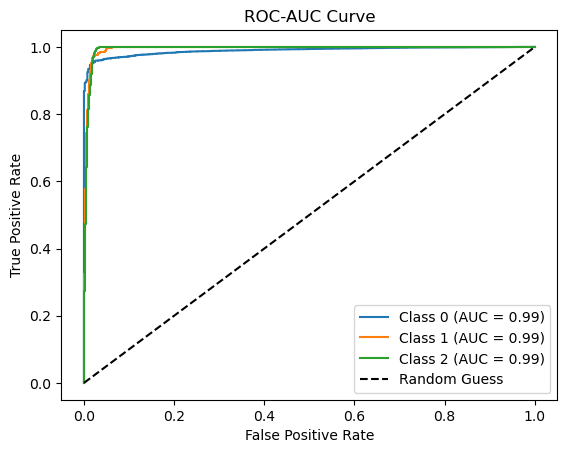

In [12]:
# Binarize the labels for one-vs-rest classification
classes = [0, 1, 2]
target_test_binarized = label_binarize(target_test, classes=classes)

# Compute ROC curve and ROC-AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(target_test_binarized[:, i], target_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure()
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')

# Plot the diagonal
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

# Configure the plot
plt.title('ROC-AUC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

##### Precision-Recall Curves

Precision-recall curves are often more informative for imbalanced datasets. They focus on the trade-off between precision and recall for each class.

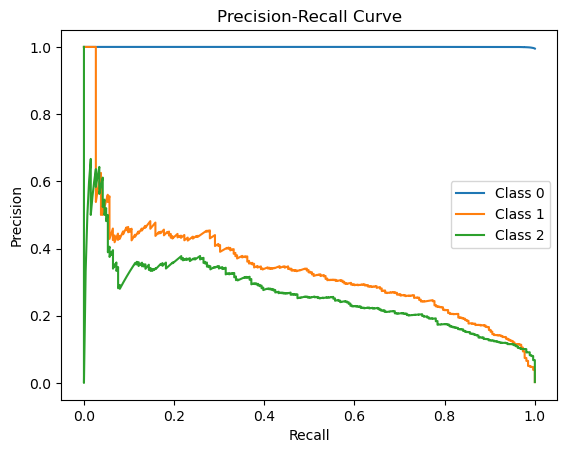

In [13]:
# Plot precision-recall curves for each class
for i in range(3):  # Assuming 3 classes (0, 1, 2)
    precision, recall, _ = precision_recall_curve(target_test_binarized[:, i], target_pred_prob[:, i])
    plt.plot(recall, precision, label=f'Class {i}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


## 6. Time Series Cross-Validation

In [14]:
# Use TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)
for fold, (train_idx, val_idx) in enumerate(tscv.split(attributes)):
    attributes_train_fold, attributes_val_fold = attributes.iloc[train_idx], attributes.iloc[val_idx]
    target_train_fold, target_val_fold = target.iloc[train_idx], target.iloc[val_idx]

    # Apply SMOTE to the training fold
    attributes_train_fold_smote, target_train_fold_smote = smote.fit_resample(attributes_train_fold, target_train_fold)

    # Train model
    model_xgb.fit(attributes_train_fold_smote, target_train_fold_smote)

    # Validate
    target_val_pred = model_xgb.predict(attributes_val_fold)
    print(f"Fold {fold+1} Classification Report")
    print(classification_report(target_val_fold, target_val_pred))


[10:59:16] ======== Monitor (0): HostSketchContainer ========
[10:59:16] AllReduce: 0.016119s, 1 calls @ 16119us

[10:59:16] MakeCuts: 0.016285s, 1 calls @ 16285us

[10:59:16] DEBUG: D:\bld\xgboost-split_1732150467793\work\src\gbm\gbtree.cc:130: Using tree method: 0


C:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:59:16] WARNING: D:\bld\xgboost-split_1732150467793\work\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[10:59:37] ======== Monitor (0): Learner ========
[10:59:37] Configure: 0.00074s, 1 calls @ 740us

[10:59:37] EvalOneIter: 0.003476s, 300 calls @ 3476us

[10:59:37] GetGradient: 1.73539s, 300 calls @ 1735388us

[10:59:37] PredictRaw: 0.001505s, 300 calls @ 1505us

[10:59:37] UpdateOneIter: 20.4269s, 300 calls @ 20426930us

[10:59:37] ======== Monitor (0): GBTree ========
[10:59:37] BoostNewTrees: 18.6864s, 300 calls @ 18686397us

[10:59:37] CommitModel: 0.000322s, 300 calls @ 322us

[10:59:37] ======== Monitor (0): HistUpdater ========
[10:59:37] BuildHistogram: 5.24339s, 4500 calls @ 5243389us

[10:59:37] EvaluateSplits: 2.02389s, 5400 calls @ 2023891us

[10:59:37] InitData: 0.876132s, 900 calls @ 876132us

[10:59:37] InitRoot: 5.09693s, 900 calls @ 5096930us

[10:59:37] LeafPartition: 0.000226s, 900 calls @ 226us

[10:59:37] UpdatePosition: 1.40314s, 5400 calls @ 1403137us

[10:59:37] UpdatePredictionCache: 0.286054s, 900 calls @ 286054us

[10:59:37] UpdateTree: 14.6302s, 900 calls @

C:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:59:39] WARNING: D:\bld\xgboost-split_1732150467793\work\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[11:00:17] ======== Monitor (0): Learner ========
[11:00:17] Configure: 0.000404s, 1 calls @ 404us

[11:00:17] EvalOneIter: 0.003521s, 300 calls @ 3521us

[11:00:17] GetGradient: 3.4779s, 300 calls @ 3477905us

[11:00:17] PredictRaw: 0.001588s, 300 calls @ 1588us

[11:00:17] UpdateOneIter: 38.2944s, 300 calls @ 38294386us

[11:00:17] ======== Monitor (0): GBTree ========
[11:00:17] BoostNewTrees: 34.8114s, 300 calls @ 34811405us

[11:00:17] CommitModel: 0.000352s, 300 calls @ 352us

[11:00:17] ======== Monitor (0): HistUpdater ========
[11:00:17] BuildHistogram: 9.53684s, 4500 calls @ 9536838us

[11:00:17] EvaluateSplits: 2.35579s, 5400 calls @ 2355790us

[11:00:17] InitData: 1.69674s, 900 calls @ 1696744us

[11:00:17] InitRoot: 9.91314s, 900 calls @ 9913136us

[11:00:17] LeafPartition: 0.000289s, 900 calls @ 289us

[11:00:17] UpdatePosition: 3.298s, 5400 calls @ 3297997us

[11:00:17] UpdatePredictionCache: 0.625449s, 900 calls @ 625449us

[11:00:17] UpdateTree: 26.7811s, 900 calls @ 2

C:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:00:20] WARNING: D:\bld\xgboost-split_1732150467793\work\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[11:01:17] ======== Monitor (0): Learner ========
[11:01:17] Configure: 0.000649s, 1 calls @ 649us

[11:01:17] EvalOneIter: 0.003641s, 300 calls @ 3641us

[11:01:17] GetGradient: 5.29443s, 300 calls @ 5294433us

[11:01:17] PredictRaw: 0.003415s, 300 calls @ 3415us

[11:01:17] UpdateOneIter: 57.2644s, 300 calls @ 57264365us

[11:01:17] ======== Monitor (0): GBTree ========
[11:01:17] BoostNewTrees: 51.9624s, 300 calls @ 51962407us

[11:01:17] CommitModel: 0.000374s, 300 calls @ 374us

[11:01:17] ======== Monitor (0): HistUpdater ========
[11:01:17] BuildHistogram: 14.0353s, 4500 calls @ 14035267us

[11:01:17] EvaluateSplits: 2.59425s, 5400 calls @ 2594251us

[11:01:17] InitData: 2.5696s, 900 calls @ 2569600us

[11:01:17] InitRoot: 14.8923s, 900 calls @ 14892328us

[11:01:17] LeafPartition: 0.000234s, 900 calls @ 234us

[11:01:17] UpdatePosition: 5.64527s, 5400 calls @ 5645275us

[11:01:17] UpdatePredictionCache: 1.07125s, 900 calls @ 1071253us

[11:01:17] UpdateTree: 39.7233s, 900 calls

C:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:01:21] WARNING: D:\bld\xgboost-split_1732150467793\work\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[11:02:37] ======== Monitor (0): Learner ========
[11:02:37] Configure: 0.000371s, 1 calls @ 371us

[11:02:37] EvalOneIter: 0.003949s, 300 calls @ 3949us

[11:02:37] GetGradient: 7.07934s, 300 calls @ 7079339us

[11:02:37] PredictRaw: 0.002979s, 300 calls @ 2979us

[11:02:37] UpdateOneIter: 75.8331s, 300 calls @ 75833118us

[11:02:37] ======== Monitor (0): GBTree ========
[11:02:37] BoostNewTrees: 68.7468s, 300 calls @ 68746791us

[11:02:37] CommitModel: 0.000444s, 300 calls @ 444us

[11:02:37] ======== Monitor (0): HistUpdater ========
[11:02:37] BuildHistogram: 18.5232s, 4500 calls @ 18523205us

[11:02:37] EvaluateSplits: 2.64137s, 5400 calls @ 2641367us

[11:02:37] InitData: 3.43892s, 900 calls @ 3438923us

[11:02:37] InitRoot: 19.9211s, 900 calls @ 19921129us

[11:02:37] LeafPartition: 0.000273s, 900 calls @ 273us

[11:02:37] UpdatePosition: 7.74531s, 5400 calls @ 7745310us

[11:02:37] UpdatePredictionCache: 1.54973s, 900 calls @ 1549731us

[11:02:37] UpdateTree: 52.2543s, 900 call

C:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:02:41] WARNING: D:\bld\xgboost-split_1732150467793\work\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[11:04:19] ======== Monitor (0): Learner ========
[11:04:19] Configure: 0.000794s, 1 calls @ 794us

[11:04:19] EvalOneIter: 0.004007s, 300 calls @ 4007us

[11:04:19] GetGradient: 9.03462s, 300 calls @ 9034620us

[11:04:19] PredictRaw: 0.005906s, 300 calls @ 5906us

[11:04:19] UpdateOneIter: 97.4563s, 300 calls @ 97456265us

[11:04:19] ======== Monitor (0): GBTree ========
[11:04:19] BoostNewTrees: 88.4112s, 300 calls @ 88411190us

[11:04:19] CommitModel: 0.000428s, 300 calls @ 428us

[11:04:19] ======== Monitor (0): HistUpdater ========
[11:04:19] BuildHistogram: 23.8409s, 4500 calls @ 23840906us

[11:04:19] EvaluateSplits: 2.81981s, 5400 calls @ 2819806us

[11:04:19] InitData: 4.67652s, 900 calls @ 4676517us

[11:04:19] InitRoot: 25.4858s, 900 calls @ 25485819us

[11:04:19] LeafPartition: 0.000273s, 900 calls @ 273us

[11:04:19] UpdatePosition: 10.2432s, 5400 calls @ 10243157us

[11:04:19] UpdatePredictionCache: 2.17258s, 900 calls @ 2172584us

[11:04:19] UpdateTree: 67.0942s, 900 cal

## 7. Hyperparameter Tuning

We will use **GridSearchCV** and **Optuna** for tuning.

##### Recommended Parameters to Tune:
- `max_depth` (e.g., 3, 5, 7): Controls tree depth. Deeper trees can model complex patterns but risk overfitting.
- `learning_rate` (e.g., 0.01, 0.05, 0.1): Smaller values improve convergence stability.
- `n_estimators` (e.g., 100, 300, 500): More estimators improve performance but increase training time.
- `subsample` (e.g., 0.6, 0.8, 1.0): Helps with overfitting by randomly sampling rows.
- `colsample_bytree` (e.g., 0.6, 0.8, 1.0): Helps with overfitting by randomly sampling features.
- `scale_pos_weight` (e.g., 1, 10, 50): Adjusts for class imbalance. Compute as `total_negative_samples / total_positive_samples`.

### 7.1. Optuna

##### Key Notes:
1. **SMOTE** is applied only to the training data within each fold to avoid data leakage.
2. Use a meaningful evaluation metric for imbalanced datasets. Here, **weighted F1-score** is used.
3. Adjust the `n_trials` parameter in `study.optimize()` based on computational resources.
4. Optuna’s logging and visualization tools help understand hyperparameter impact.

#### 7.1.1. Define the Objective Function

The objective function tests different hyperparameter combinations and evaluates their performance using cross-validation.

In [ ]:
# def objective(trial):
#     optuna.logging.set_verbosity(optuna.logging.DEBUG)
    
#     # Define the hyperparameters to tune
#     param = {
#         'objective': 'multi:softmax',  # Multiclass classification
#         'num_class': 3,               # Number of target classes
#         'eval_metric': 'mlogloss',    # Evaluation metric
#         'max_depth': trial.suggest_int('max_depth', 3, 10),  # Tree depth
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),  # Step size
#         'n_estimators': trial.suggest_int('n_estimators', 100, 500),  # Boosting rounds
#         'subsample': trial.suggest_float('subsample', 0.6, 1.0),  # Row sampling
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),  # Feature sampling
#         # 'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 50),  # Class imbalance - for  a multiclass classification  this parameter can't be applied.
#         'random_state': 42
#     }
    
#     # Use TimeSeriesSplit for time series cross-validation
#     tscv = TimeSeriesSplit(n_splits=5)
    
#     f1_scores = []  # Store F1-scores for each fold
    
#     for train_idx, val_idx in tscv.split(attributes):
#         attributes_train, attributes_val = attributes.iloc[train_idx], attributes.iloc[val_idx]
#         target_train, target_val = target.iloc[train_idx], target.iloc[val_idx]

#         # Apply SMOTE to handle class imbalance in training data
#         smote = SMOTE(random_state=42)
#         attributes_train_smote, target_train_smote = smote.fit_resample(attributes_train, target_train)

#         # Train XGBoost model
#         model = XGBClassifier(**param)
#         model.fit(attributes_train_smote, target_train_smote)

#         # Make predictions
#         target_pred = model.predict(attributes_val)

#         # Evaluate using F1-score (weighted)
#         f1 = f1_score(target_val, target_pred, average='weighted')
#         f1_scores.append(f1)
    
#     # Return the mean F1-score across all folds
#     return np.mean(f1_scores)


In [91]:
def objective(trial):
    # Define the hyperparameters to tune
    param = {
        'objective': 'multi:softmax',  # Multiclass classification
        'num_class': 3,               # Number of target classes
        'eval_metric': 'mlogloss',    # Evaluation metric
        'max_depth': trial.suggest_int('max_depth', 3, 10),  # Tree depth
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),  # Step size
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),  # Boosting rounds
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),  # Row sampling
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),  # Feature sampling
        # 'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 50),  # Class imbalance - for  a multiclass classification  this parameter can't be applied.
        'random_state': 42
    }
    
    # Use TimeSeriesSplit for time series cross-validation
    tscv = TimeSeriesSplit(n_splits=5)
    
    f1_scores = []  # Store F1-scores for each fold
    
    for train_idx, val_idx in tscv.split(attributes):
        attributes_train, attributes_val = attributes.iloc[train_idx], attributes.iloc[val_idx]
        target_train, target_val = target.iloc[train_idx], target.iloc[val_idx]

        # Apply SMOTE to handle class imbalance in training data
        smote = SMOTE(random_state=42)
        attributes_train_smote, target_train_smote = smote.fit_resample(attributes_train, target_train)

        # Train XGBoost model
        model = XGBClassifier(**param)
        model.fit(attributes_train_smote, target_train_smote)

        # Make predictions
        target_pred = model.predict(attributes_val)

        # Evaluate using F1-score (weighted)
        f1 = f1_score(target_val, target_pred, average='weighted')
        f1_scores.append(f1)
    
    # Return the mean F1-score across all folds
    return np.mean(f1_scores)


#### 7.1.2. Run the Optuna Study

In [52]:
# Create a study and optimize
study = optuna.create_study(direction='maximize')
#study.optimize(objective, n_trials=1)  # Adjust the number of trials as needed

# Output the best hyperparameters
print("Best Parameters:", study.best_params)
print("Best F1-Score:", study.best_value)
print("Best Trial:", study.best_trial)


[I 2024-11-26 17:54:31,061] A new study created in memory with name: no-name-a483ad25-8619-4539-b538-859a70e84e09


ValueError: No trials are completed yet.

### 7.1.2 MLFlow

In [88]:
experiment_name = "BTC_XGBoost_Optuna"
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None: 
    mlflow.create_experiment(experiment_name)

In [89]:
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='file:///C:/Users/valch/OneDrive/Desktop/03.Machine%20Learning-September-2024/Exam/02.Exam-Project/01.Repo/Algorithmic-Trading-Bot/Notebook/mlruns/683265721719547756', creation_time=1732646850521, experiment_id='683265721719547756', last_update_time=1732646850521, lifecycle_stage='active', name='BTC_XGBoost_Optuna', tags={}>

In [90]:
with mlflow.start_run(run_name = "BTC_XGBoost_Optuna_SMOTE - test flow"):
    mlflow.log_param("train size", len(attributes_train))
    mlflow.log_param("test size", len(attributes_test))

    # Create a Optuna study and optimize
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=3)  # Adjust the number of trials as needed

    # Save Optuna visualizations as artifacts
    optimization_history_plot = vis.plot_optimization_history(study)
    param_importance_plot = vis.plot_param_importances(study)
    
    # Save visualizations to files
    optimization_history_plot.write_html("optimization_history.html")
    param_importance_plot.write_html("param_importances.html")

    # Log visualization artifacts to MLflow
    mlflow.log_artifact("optimization_history.html")
    mlflow.log_artifact("param_importances.html")

    mlflow.log_params(study.best_params)
    mlflow.log_metric("best_F1-score", study.best_value)

    # Output the best hyperparameters
    print("Best Parameters:", study.best_params)
    print("Best F1-Score:", study.best_value)
    print("Best Trial:", study.best_trial)

    # Train best model
    model_xgb = XGBClassifier(**study.best_params)
    model_xgb.fit(attributes_train, target_train)

    # Validate
    target_train_pred = model_xgb.predict(attributes_train)
    classification_train_report = classification_report(target_train, target_train_pred)

    target_test_pred = model_xgb.predict(attributes_test)
    classification_test_report = classification_report(target_test, target_test_pred)
   
    print("classification_train_report: ", classification_train_report)
    print("classification_test_report: ", classification_test_report)

    # Log metrics
    mlflow.log_metric("train_accuracy", model_xgb.score(attributes_train, target_train))
    mlflow.log_metric("test_accuracy", model_xgb.score(attributes_test, target_test))

    with open("train_report.txt",  "w") as f:
        f.write(classification_train_report)
    with open("test_report.txt",  "w") as f:
        f.write(classification_test_report)
        
    pickle.dump(model_xgb, open("model_xgb.pkl", "wb"))

    # Log artifacts to MLflow
    mlflow.log_artifact("model_xgb.pkl")
    mlflow.log_artifact("train_report.txt")
    mlflow.log_artifact("test_report.txt")

[I 2024-11-26 19:47:32,748] A new study created in memory with name: no-name-58c93ef2-b23f-469f-a9c6-09216e950f84
[I 2024-11-26 19:48:06,884] Trial 0 finished with value: 0.9302441154321496 and parameters: {'max_depth': 4, 'learning_rate': 0.05526975923821381, 'n_estimators': 15, 'subsample': 0.7609950028254728, 'colsample_bytree': 0.8335032193487361}. Best is trial 0 with value: 0.9302441154321496.
[I 2024-11-26 19:48:52,839] Trial 1 finished with value: 0.9517601823911453 and parameters: {'max_depth': 8, 'learning_rate': 0.03912624271735095, 'n_estimators': 18, 'subsample': 0.9291939609772408, 'colsample_bytree': 0.9445125030474352}. Best is trial 1 with value: 0.9517601823911453.
[I 2024-11-26 19:49:35,997] Trial 2 finished with value: 0.9673932788850454 and parameters: {'max_depth': 8, 'learning_rate': 0.15048930513062858, 'n_estimators': 15, 'subsample': 0.9861631768372155, 'colsample_bytree': 0.7292935856355963}. Best is trial 2 with value: 0.9673932788850454.


Best Parameters: {'max_depth': 8, 'learning_rate': 0.15048930513062858, 'n_estimators': 15, 'subsample': 0.9861631768372155, 'colsample_bytree': 0.7292935856355963}
Best F1-Score: 0.9673932788850454
Best Trial: FrozenTrial(number=2, state=1, values=[0.9673932788850454], datetime_start=datetime.datetime(2024, 11, 26, 19, 48, 52, 840981), datetime_complete=datetime.datetime(2024, 11, 26, 19, 49, 35, 996902), params={'max_depth': 8, 'learning_rate': 0.15048930513062858, 'n_estimators': 15, 'subsample': 0.9861631768372155, 'colsample_bytree': 0.7292935856355963}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.2, log=True, low=0.01, step=None), 'n_estimators': IntDistribution(high=20, log=False, low=10, step=1), 'subsample': FloatDistribution(high=1.0, log=False, low=0.6, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.6, step=None)}

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\P

classification_train_report:                precision    recall  f1-score   support

           0       0.99      1.00      1.00    420626
           1       0.00      0.00      0.00      1040
           2       0.00      0.00      0.00      1194

    accuracy                           0.99    422860
   macro avg       0.33      0.33      0.33    422860
weighted avg       0.99      0.99      0.99    422860

classification_test_report:                precision    recall  f1-score   support

           0       0.99      1.00      1.00    105186
           1       0.00      0.00      0.00       265
           2       0.00      0.00      0.00       264

    accuracy                           0.99    105715
   macro avg       0.33      0.33      0.33    105715
weighted avg       0.99      0.99      0.99    105715



#### 7.1.3. Train the Final Model with Best Parameters

Once the study is complete, use the best parameters to train the model on the entire training dataset:

In [ ]:
# Retrieve the best hyperparameters
best_params = study.best_params

# Train the model on the full training set
final_model = XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    eval_metric='mlogloss',
    **best_params
)

# Apply SMOTE
attributes_train_smote, target_train_smote = smote.fit_resample(attributes_train, target_train)

# Train the final model
final_model.fit(attributes_train_smote, target_train_smote)

# Evaluate on the test set
target_test_pred = final_model.predict(attributes_test)
print(classification_report(target_test, target_test_pred))

#### 7.1.4. Visualize the Study

In [ ]:
# Visualize parameter importance
optuna.visualization.plot_param_importances(study).show()

# Visualize optimization history
optuna.visualization.plot_optimization_history(study).show()

# Visualize hyperparameter values
optuna.visualization.plot_parallel_coordinate(study).show()


### 7.3. GridSearchCV

##### GridSearchCV

In [ ]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 300],
    # 'n_estimators': [100, 300, 500],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'scale_pos_weight': [1, 10, 50]
}

grid_search = GridSearchCV(
    estimator=XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss', random_state=42),
    param_grid=param_grid,
    scoring='f1_weighted',  # Use an appropriate scoring metric
    cv=tscv,                # Use TimeSeriesSplit
    verbose=4,
    n_jobs=9
)

# grid_search.fit(attributes_train_smote, target_train_smote)
# print("Best Parameters:", grid_search.best_params_)

# Output best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best accuracy:", grid_search.best_score_)

# Evaluate on test set
best_model = grid_search.best_estimator_
test_score = best_model.score(attributes_test, target_test)
print("Test set accuracy:", test_score)